## Lesson-07 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
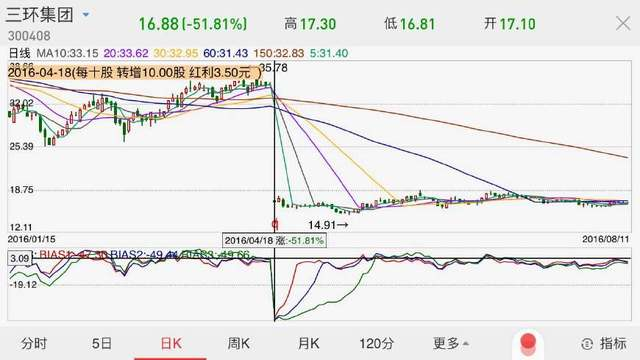

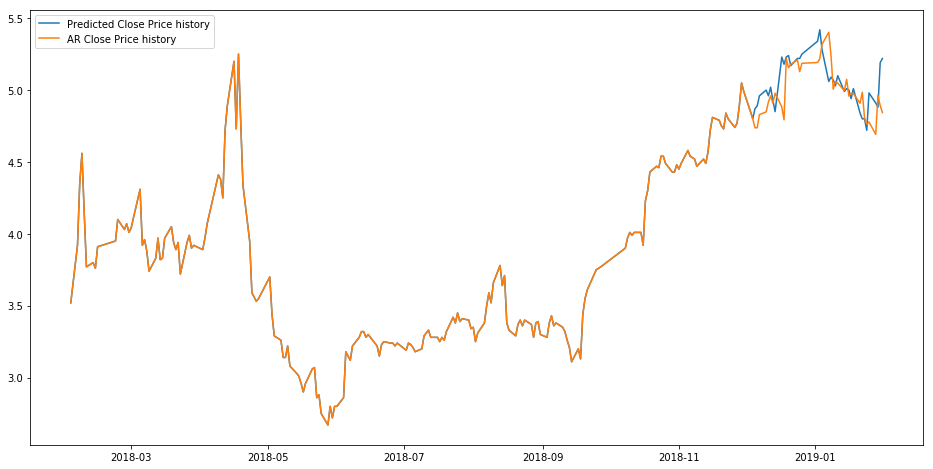

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [31]:
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))

True


In [32]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [33]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [34]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [35]:
n_categories

18

In [36]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [37]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [38]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

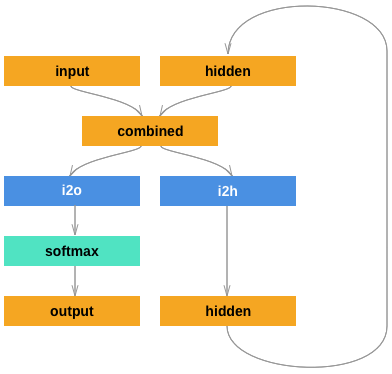

In [210]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [211]:
rnn = RNN(n_letters, n_hidden, n_categories)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [41]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [42]:
output

tensor([[-2.8696, -2.9094, -2.8919, -3.0306, -2.9843, -2.9221, -2.8396, -2.8592,
         -3.0117, -2.8691, -2.9325, -2.8630, -2.8455, -2.7607, -2.8722, -2.8597,
         -2.9088, -2.8339]], grad_fn=<LogSoftmaxBackward>)

In [43]:
next_hidden

tensor([[ 0.0391, -0.0498,  0.0897, -0.0775,  0.0493, -0.0298,  0.0289,  0.0505,
          0.0266, -0.0453, -0.0301, -0.0754, -0.0367,  0.0303, -0.0658,  0.0483,
          0.1042, -0.1184, -0.0960, -0.0086,  0.0158, -0.0082,  0.1440,  0.0413,
         -0.0822, -0.0839,  0.0702, -0.0861, -0.1190,  0.0521,  0.1202,  0.0736,
         -0.0245, -0.0038,  0.0162, -0.0016, -0.0851,  0.0202, -0.0249,  0.0298,
         -0.0868, -0.0443, -0.0987, -0.0277,  0.0245, -0.0262, -0.0999, -0.0085,
          0.0162,  0.0838,  0.0650,  0.0031, -0.0449, -0.0107,  0.0081,  0.0626,
         -0.0146, -0.0062,  0.0633,  0.0705, -0.0044, -0.0325,  0.0186, -0.0289,
         -0.0417, -0.0876, -0.0151, -0.0282, -0.0054, -0.0139,  0.0724, -0.0637,
          0.0218,  0.0342, -0.1346, -0.1004,  0.0065,  0.0398,  0.0368, -0.0566,
         -0.0395, -0.0774, -0.0307, -0.0311, -0.0016,  0.0067, -0.0242, -0.0237,
          0.0950,  0.0609,  0.0431,  0.0117, -0.0571, -0.0328, -0.0116, -0.1145,
          0.0583,  0.0154, -

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [44]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8696, -2.9094, -2.8919, -3.0306, -2.9843, -2.9221, -2.8396, -2.8592,
         -3.0117, -2.8691, -2.9325, -2.8630, -2.8455, -2.7607, -2.8722, -2.8597,
         -2.9088, -2.8339]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [45]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [46]:
print(category_from_output(output))

('Portuguese', 13)


### 1.8 随机生成训练数据

In [198]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Spanish / line = Vives
category = Irish / line = O'Kane
category = French / line = Charbonneau
category = Russian / line = Baidakov
category = German / line = Kundert
category = Scottish / line = Muir
category = Czech / line = Cernochova
category = English / line = Mcdermott
category = Russian / line = Novoselitsky
category = Italian / line = Pozzi


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [208]:
criterion = nn.CrossEntropyLoss()

In [49]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [50]:
import time
import math

n_iters = 20000 # 这个数字你可以调大一些
print_every = 5000
plot_every = 500


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 25% (0m 8s) 2.9934 Aberquero / Russian ✗ (Spanish)
10000 50% (0m 17s) 1.9760 Ventura / Portuguese ✓
15000 75% (0m 26s) 0.5913 Dalianis / Greek ✓
20000 100% (0m 34s) 2.0123 Severin / Spanish ✗ (French)


### 1.9 观察Loss的变化

In [51]:
all_losses

[2.8790138077735903,
 2.8586724190711976,
 2.8354430088996887,
 2.8181567492485047,
 2.794760298252106,
 2.7629368257522584,
 2.713281783103943,
 2.646762685894966,
 2.575281255304813,
 2.504302919268608,
 2.4932165211439132,
 2.455645710706711,
 2.3642906116247175,
 2.3699492510557176,
 2.2974368488788603,
 2.3072242515683175,
 2.2487452265620234,
 2.271461015045643,
 2.2322601088881493,
 2.213722580909729,
 2.1541678134799005,
 2.12205074262619,
 2.1008798528015613,
 2.1436278491914273,
 2.034990070939064,
 2.119346328765154,
 2.0755556304082274,
 1.9739424110352992,
 1.9925853706300258,
 1.9230389479398728,
 1.9334034775048494,
 1.958680010393262,
 1.962766433402896,
 1.9282531793043018,
 1.9370419299602508,
 1.9014065964221953,
 1.9161902390271426,
 1.8928207120597362,
 1.9041427076905966,
 1.779981935625896]

In [52]:
%matplotlib inline

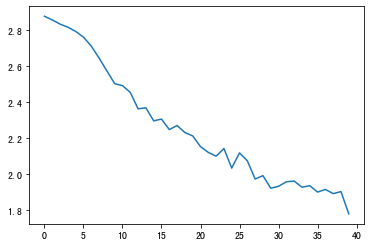

In [53]:
plt.plot(all_losses)

In [54]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.67) Russian
(-1.69) Czech
(-1.74) Polish

> Jackson
(-1.75) Russian
(-1.90) Scottish
(-2.07) English

> Satoshi
(-1.33) Italian
(-1.85) Polish
(-2.19) Czech


## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

> todo

In [200]:
#把optimizer改成Adam

def train(category_tensor, line_tensor, net, optimizer):
    hidden = net.initHidden()

    net.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = net(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()
    # Add parameters' gradients to their values, multiplied by learning rate
#     for p in rnn.parameters():
#         p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [201]:


def test(net,n_iters = 20000, print_every = 5000, plot_every = 500,learning_rate = 0.005):
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    start = time.time()

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = sample_trainning()
        output, loss = train(category_tensor, line_tensor,net,optimizer)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    
    plt.plot(all_losses)
    return all_losses

In [202]:
n_hidden = 128
RNN = RNN(n_letters, n_hidden, n_categories)

5000 25% (0m 9s) 0.3512 Zhao / Chinese ✓
10000 50% (0m 17s) 2.4089 Jans / Dutch ✗ (German)
15000 75% (0m 28s) 3.7736 Kwak / Polish ✗ (Korean)
20000 100% (0m 38s) 1.8703 Lawlor / Scottish ✗ (English)


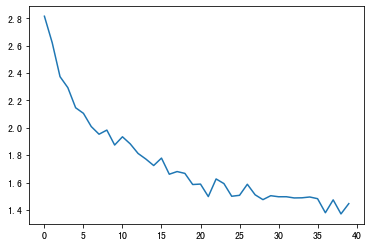

In [186]:
RN_loss = test(RNN,n_iters = 20000,learning_rate = 0.001)

In [71]:
class RNN_2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_2, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        #加了一层output到output的linear层
        self.o2o = nn.Linear(output_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        #前向也需要加
        output_combined = torch.cat((output, hidden), 1)
        output = self.o2o(output_combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)



In [72]:
n_hidden = 128
RNN_2 = RNN_2(n_letters, n_hidden, n_categories)

5000 25% (0m 10s) 3.6547 Nave / French ✗ (Italian)
10000 50% (0m 21s) 0.3314 Sienkiewicz / Polish ✓
15000 75% (0m 41s) 1.8806 Blanchett / German ✗ (French)
20000 100% (0m 59s) 1.2440 Yarwood / English ✓


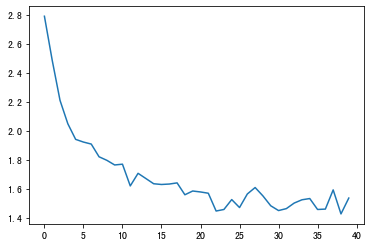

In [73]:
RNN_2_loss = test(RNN_2,n_iters = 20000,learning_rate = 0.001)

In [75]:
class RNN_3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, combined_size = 64):
        super(RNN_3, self).__init__()

        self.hidden_size = hidden_size
        #加了一层input和hidden到combined的linear层
        self.ih2c = nn.Linear(input_size + hidden_size, combined_size)
        self.i2h = nn.Linear(combined_size, hidden_size)
        self.i2o = nn.Linear(combined_size, output_size)
        #加了一层output到output的linear层
        self.o2o = nn.Linear(output_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        comb = self.ih2c(combined)
        hidden = self.i2h(comb)
        output = self.i2o(comb)
        #前向也需要加
        output_combined = torch.cat((output, hidden), 1)
        output = self.o2o(output_combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [76]:
RNN_3 = RNN_3(n_letters, n_hidden, n_categories)

5000 25% (0m 9s) 1.9408 Yeon / Scottish ✗ (Korean)
10000 50% (0m 17s) 3.6059 John / Korean ✗ (Irish)
15000 75% (0m 26s) 0.6331 Jong / Korean ✓
20000 100% (0m 35s) 0.7916 Chin / Korean ✓


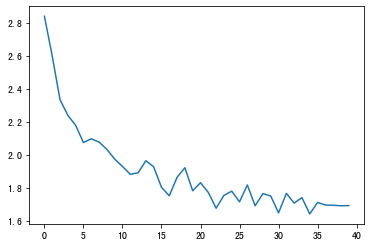

In [77]:
RNN_3_loss = test(RNN_3,n_iters = 20000,learning_rate = 0.001)

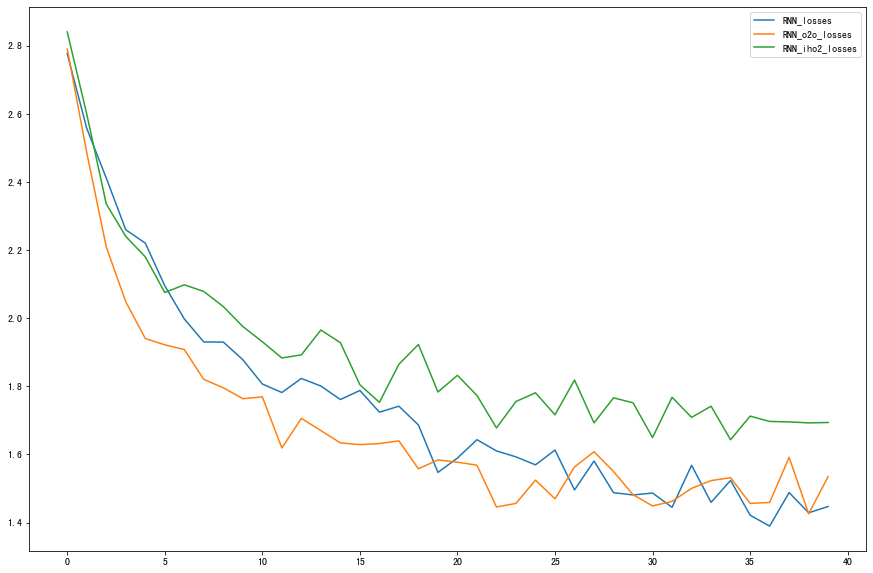

In [83]:

plt.figure(figsize=(15,10))
plt.plot(RN_loss,label='RNN_losses')
plt.plot(RNN_2_loss,label='RNN_o2o_losses')
plt.plot(RNN_3_loss,label='RNN_iho2_losses')
plt.legend()

加了一层以后好像效果没有变好


### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

In [104]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers = 1, batch_size = 1):
        super(LSTM_net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.layers = layers
        self.lstm_cell = nn.LSTM(input_size, hidden_size, layers)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        #
        out, hidden = self.lstm_cell(input.reshape(1, self.batch_size, self.input_size), hidden)#(seq_len, batch_size, input_dim)
        output = self.h2o(out[:, -1, :])#out[:, -1, :]
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):#有一个turple
        return (torch.zeros(self.layers,self.batch_size,self.hidden_size), torch.zeros(self.layers,self.batch_size,self.hidden_size))

In [105]:
n_hidden = 128
LSTM = LSTM_net(n_letters, n_hidden, n_categories)

5000 25% (0m 28s) 0.9859 Ho / Korean ✓
10000 50% (0m 45s) 6.6339 Cham / Vietnamese ✗ (Arabic)
15000 75% (1m 6s) 2.8835 Tunison / Scottish ✗ (Dutch)
20000 100% (1m 26s) 0.2898 Pierre / French ✓


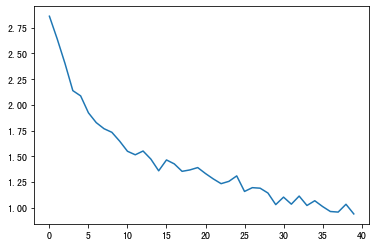

In [106]:
LSTM_loss = test(LSTM,n_iters = 20000,learning_rate = 0.001)

In [159]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers = 1):
        super(GRU_net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
#         self.batch_size = batch_size
        self.layers = layers
        self.gru_cell = nn.GRU(input_size, hidden_size, layers)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        out, hidden = self.gru_cell(input.reshape(1, 1, self.input_size), hidden)
        output = self.h2o(out[:, -1, :])
        #output = self.h2o(hidden.view(-1, self.hidden_size)) when layer == 1
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.layers, 1, self.hidden_size)

In [108]:

n_hidden = 128
GRU = GRU_net(n_letters, n_hidden, n_categories)

5000 25% (0m 26s) 1.1590 Shin / Chinese ✗ (Korean)
10000 50% (0m 56s) 0.6299 Rim / Korean ✓
15000 75% (1m 13s) 2.1369 Lamar / Arabic ✗ (French)
20000 100% (1m 31s) 0.0282 Sotiris / Greek ✓


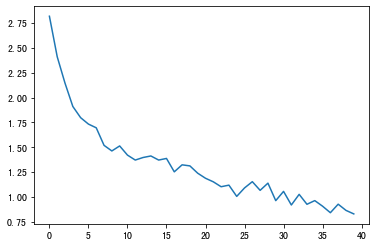

In [109]:
GRU_loss = test(GRU,n_iters = 20000,learning_rate = 0.001)

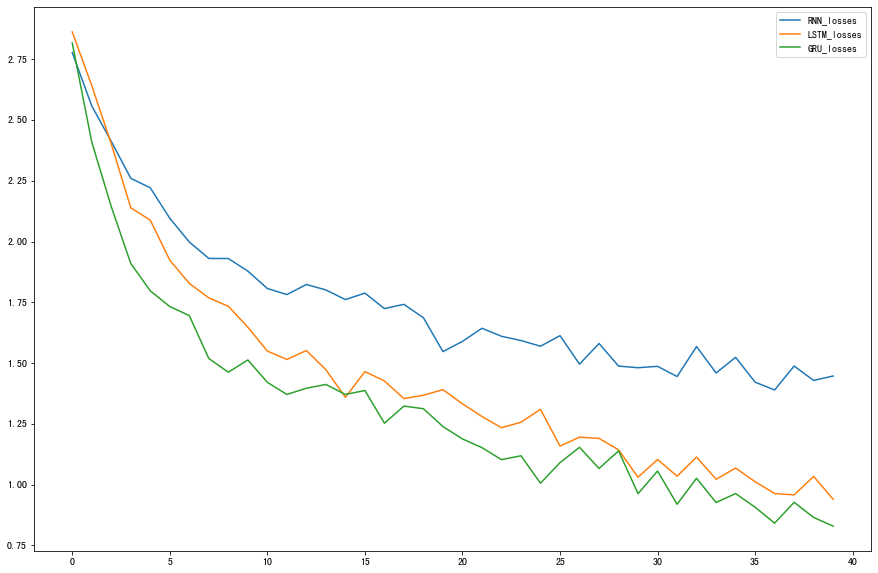

In [110]:
plt.figure(figsize=(15,10))
plt.plot(RN_loss,label='RNN_losses')
plt.plot(LSTM_loss,label='LSTM_losses')
plt.plot(GRU_loss,label='GRU_losses')
plt.legend()

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

In [162]:
class multi_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers = 1,batch_size = 1):
        super(multi_RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.layers = layers
        self.batch_size = batch_size
        self.rnn_cell = nn.RNN(input_size, hidden_size, layers)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        out, hidden = self.rnn_cell(input.reshape(1, self.batch_size, self.input_size), hidden)
        output = self.h2o(out[:, -1, :])
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.layers, self.batch_size, self.hidden_size)

In [163]:
multiRNN = multi_RNN(n_letters, n_hidden, n_categories, layers = 2,batch_size = 1)

5000 25% (0m 25s) 1.5823 Mizutani / Italian ✗ (Japanese)
10000 50% (0m 49s) 2.0325 Chaput / English ✗ (French)
15000 75% (1m 15s) 2.1615 Abasolo / Japanese ✗ (Spanish)
20000 100% (1m 38s) 0.1375 Araujo / Portuguese ✓


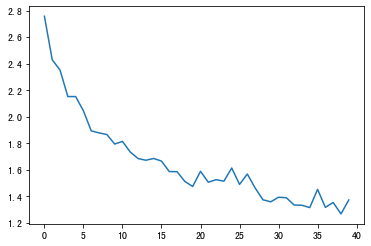

In [164]:
multiRNN_loss = test(multiRNN,n_iters = 20000,learning_rate = 0.001)

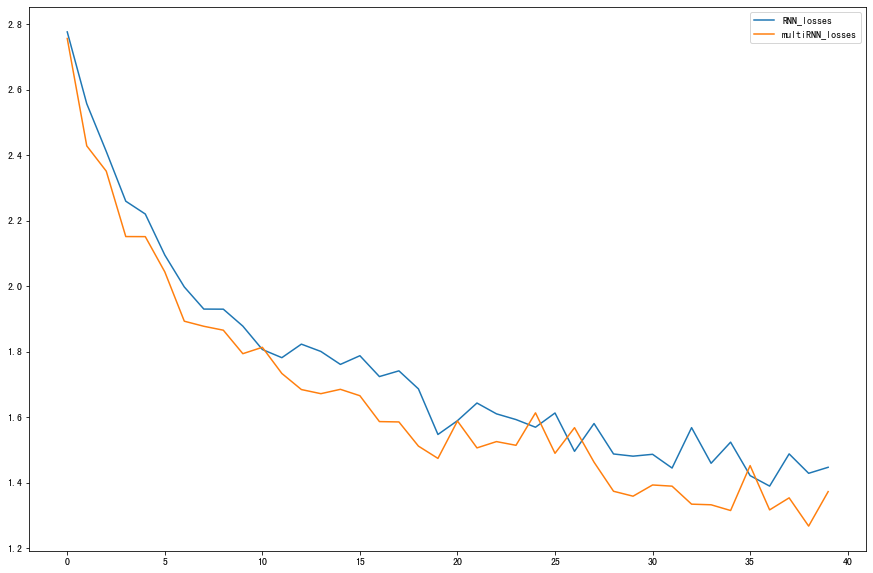

In [165]:
plt.figure(figsize=(15,10))
plt.plot(RN_loss,label='RNN_losses')
plt.plot(multiRNN_loss,label='multiRNN_losses')
plt.legend()

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

> todo

In [214]:
criterion = nn.NLLLoss()

In [215]:
def train(category_tensor, line_tensor, net, optimizer):
    hidden = net.initHidden()

    net.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = net(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()
    # Add parameters' gradients to their values, multiplied by learning rate
#     for p in rnn.parameters():
#         p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [213]:
RNN_nll = RNN(n_letters, n_hidden, n_categories)

5000 25% (0m 7s) 0.7189 Seok / Korean ✓
10000 50% (0m 14s) 1.3077 Hajicek / Polish ✗ (Czech)
15000 75% (0m 22s) 4.2560 Masin / Scottish ✗ (Italian)
20000 100% (0m 31s) 0.9852 Alemagna / Italian ✓


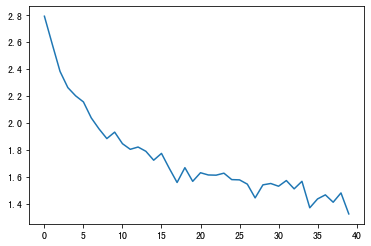

In [216]:
RNN_NLL_loss = test(RNN_nll,n_iters = 20000,learning_rate = 0.001)

比原来用crossentropy好一些

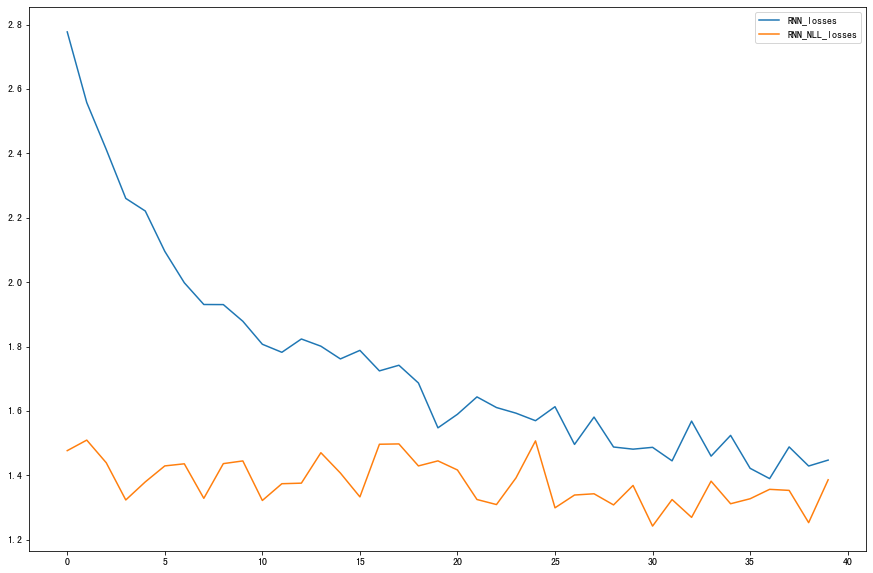

In [169]:
plt.figure(figsize=(15,10))
plt.plot(RN_loss,label='RNN_losses')
plt.plot(RNN_NLL_loss,label='RNN_NLL_losses')
plt.legend()

In [170]:
def evaluate(line_tensor, net):
    hidden = net.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = net(line_tensor[i], hidden)

    return output

def predict(input_line, net, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line), net)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [171]:
predict('wang', RNN)


> wang
(-1.30) Chinese
(-1.48) Korean
(-1.90) Scottish


In [172]:
predict('wang', RNN_2)


> wang
(-0.68) Korean
(-1.09) Chinese
(-2.96) Vietnamese


In [175]:
predict('wang', RNN_3)


> wang
(-0.31) Chinese
(-1.96) Korean
(-2.61) Vietnamese


In [176]:
predict('wang', LSTM)


> wang
(-0.65) Korean
(-0.80) Chinese
(-4.68) Scottish


In [177]:
predict('wang', GRU)


> wang
(-2.80) Korean
(-2.81) Scottish
(-2.82) Spanish


In [179]:
predict('wang', multiRNN)


> wang
(-0.26) Chinese
(-1.62) Korean
(-4.37) Dutch


In [217]:
predict('wang', RNN_nll)


> wang
(-0.56) Chinese
(-1.93) Korean
(-2.69) German



这次作业感觉回答的不是很好，有问题请助教指出，谢谢！